# GPU info

In [1]:
!nvidia-smi

Sat Apr 26 08:24:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install

In [ ]:
# !pip install -q segmentation-models-pytorch torchmetrics==1.2.0 tqdm

# Imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch.optim import SGD, lr_scheduler

import torchvision
from torchvision.transforms import v2 as T
from torchvision.transforms import functional as F
from torchvision.datasets import VisionDataset
from torchvision import tv_tensors

from torchmetrics import Dice
import segmentation_models_pytorch as smp
from torchmetrics.aggregation import MeanMetric
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio.v3 as imio

from typing import Optional, Callable
from os import getcwd, path
from glob import glob
from datetime import datetime

C:\Users\yasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.__version__, torchvision.__version__

('2.6.0+cu124', '0.21.0+cu124')

In [ ]:
# from google.colab import files
# files.upload()

# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download uw-madison-gi-tract-image-segmentation
# !unzip /content/uw-madison-gi-tract-image-segmentation.zip
# !mkdir -p /content/uw-madison-gi-tract-image-segmentation
# !mv /content/train /content/train.csv /content/sample_submission.csv /content/uw-madison-gi-tract-image-segmentation

# Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Helpers

In [ ]:
normalizer_fn = lambda x: (x - x.min()) / (x.max() - x.min())

In [ ]:
def num_parameters(model):
    params = sum([p.numel() for p in model.parameters() if p.requires_grad_])

    print(f"The number of trainable parameters: {params:,}")

In [ ]:
def rle_decode(img_size, segments):
    mask = torch.zeros(3, img_size[0] * img_size[1], dtype=torch.float32)

    for i, segment in enumerate(segments):
        if str(segment) == "nan":
            continue

        segment = segment.split()
        starts = np.array(segment[::2], dtype=np.int32) - 1
        ends = starts + np.array(segment[1::2], dtype=np.int32)

        for s, e in zip(starts, ends):
            mask[i, s:e] = 1

    return mask.reshape((3, img_size[0], img_size[1]))

In [ ]:
def train_one_epoch(dataloader, model, optimizer_fn, loss_fn, metric_fn, avg_fn, ep, device):
    model.train()

    metric_fn.reset()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

            # Calculate losses and metrics
            avg_fn.update(loss, weight=len(y_batch))
            avg_loss = avg_fn.compute().item()

            metric_fn.update(yp, y_batch)
            avg_metric = metric_fn.compute().item()

            trange.set_postfix(loss=avg_loss, metric=avg_metric)

    return model, avg_loss, avg_metric

In [ ]:
def eval_one_epoch(dataloader, model, loss_fn, metric_fn, avg_fn, device):
    model.eval()

    metric_fn.reset()
    avg_fn.reset()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Calculate losses and metrics
            avg_fn.update(loss, weight=len(y_batch))
            avg_loss = avg_fn.compute().item()

            metric_fn.update(yp, y_batch)
            avg_metric = metric_fn.compute().item()

        print(f"Eval ==> loss: {avg_loss:.4}\tmetric: {avg_metric:.4}\n")

    return avg_loss, avg_metric

In [ ]:
def loss_fn(preds, targets, alpha=0.7):
    dice_loss_fn = smp.losses.DiceLoss(mode="multilabel")
    bc_loss_fn = nn.BCEWithLogitsLoss()

    return alpha * dice_loss_fn(preds, targets) + (1 - alpha) * bc_loss_fn(preds, targets.to(torch.float32))

In [ ]:
def segmente_fn(model, img):
    if len(img.shape) == 3:
        img = img.unsqueeze(0)

    with torch.inference_mode():
        yp = model(img)

    return torch.sigmoid(yp).cpu()

# Arguments

In [ ]:
dataset_root = path.join(getcwd(), "uw-madison-gi-tract-image-segmentation")
batch_size = 64
backbone = "efficientnet-b1"
num_classes = 3

# Dataset

## Load dataset

### Load and show an image

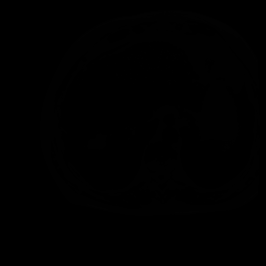

In [ ]:
img_path = path.join(f"{dataset_root}", "train", "case15/case15_day20/scans/slice_0053_266_266_1.50_1.50.png")
img = Image.open(img_path)
img

In [ ]:
img_t = T.ToTensor()(img)
img_t = normalizer_fn(img_t)
img_t.shape, img_t.dtype, img_t.min(), img_t.max()

C:\Users\yasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(torch.Size([1, 266, 266]), torch.float32, tensor(0.), tensor(1.))

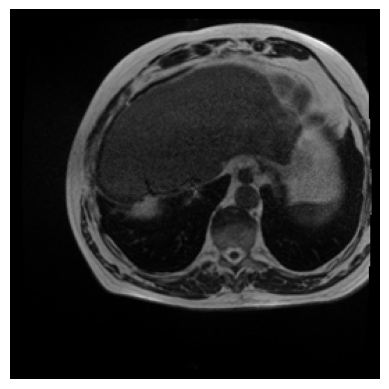

In [ ]:
plt.imshow(img_t.permute(1, 2, 0), cmap="gray")
plt.axis("off");

### Load and show a segmentation mask

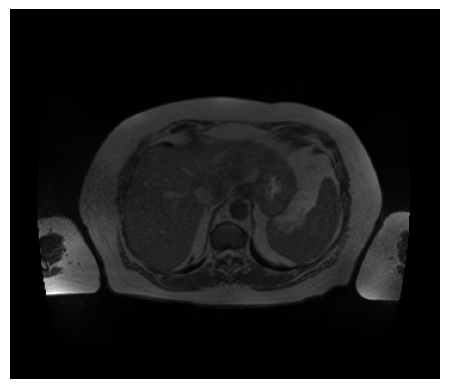

In [ ]:
img_path = path.join(f"{dataset_root}", "train", "case11/case11_day0/scans/slice_0039_360_310_1.50_1.50.png")
img = Image.open(img_path)
img_t = T.ToTensor()(img)
img_t = normalizer_fn(img_t)
plt.imshow(img_t.permute(1, 2, 0), cmap="gray")
plt.axis("off");

In [ ]:
df = pd.read_csv(r"./uw-madison-gi-tract-image-segmentation/train.csv")
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
mask_name = "case11_day0_slice_0039"

In [ ]:
sample = df[df["id"] == mask_name]
sample

,id,class,segmentation
62226,case11_day0_slice_0039,large_bowel,NaN
62227,case11_day0_slice_0039,small_bowel,NaN
62228,case11_day0_slice_0039,stomach,47020 9 47378 12 47736 15 48095 16 48454 18 48...


In [ ]:
rle_mask = sample.iloc[2]["segmentation"]
rle_mask

'47020 9 47378 12 47736 15 48095 16 48454 18 48813 20 49172 22 49532 23 49891 26 50251 27 50611 28 50970 30 51330 30 51690 30 52049 32 52409 32 52768 32 53113 8 53126 34 53470 50 53829 50 54189 50 54548 51 54908 50 55268 50 55628 49 55989 48 56350 47 56713 43 57078 37 57441 33 57803 31 58165 28 58527 26 58889 23 59250 21 59611 20 59972 18 60333 16 60695 13 61056 10 61418 7 61781 1'

In [ ]:
rle_ls = rle_mask.split(' ')
start, length = rle_ls[::2], rle_ls[1::2]
starts = np.array(start, dtype=np.int32)-1
length = np.array(length, dtype=np.int32)
ends = starts + length
starts, length, ends

(array([47019, 47377, 47735, 48094, 48453, 48812, 49171, 49531, 49890,
        50250, 50610, 50969, 51329, 51689, 52048, 52408, 52767, 53112,
        53125, 53469, 53828, 54188, 54547, 54907, 55267, 55627, 55988,
        56349, 56712, 57077, 57440, 57802, 58164, 58526, 58888, 59249,
        59610, 59971, 60332, 60694, 61055, 61417, 61780], dtype=int32),
 array([ 9, 12, 15, 16, 18, 20, 22, 23, 26, 27, 28, 30, 30, 30, 32, 32, 32,
         8, 34, 50, 50, 50, 51, 50, 50, 49, 48, 47, 43, 37, 33, 31, 28, 26,
        23, 21, 20, 18, 16, 13, 10,  7,  1], dtype=int32),
 array([47028, 47389, 47750, 48110, 48471, 48832, 49193, 49554, 49916,
        50277, 50638, 50999, 51359, 51719, 52080, 52440, 52799, 53120,
        53159, 53519, 53878, 54238, 54598, 54957, 55317, 55676, 56036,
        56396, 56755, 57114, 57473, 57833, 58192, 58552, 58911, 59270,
        59630, 59989, 60348, 60707, 61065, 61424, 61781], dtype=int32))

In [ ]:
mask = torch.zeros(img_t.numel(), dtype=torch.float32)

for s, e in zip(starts, ends):
    mask[s:e] = 1

mask.shape

torch.Size([111600])

In [ ]:
mask2 = mask.reshape(img_t.shape)
mask2.shape

torch.Size([1, 310, 360])

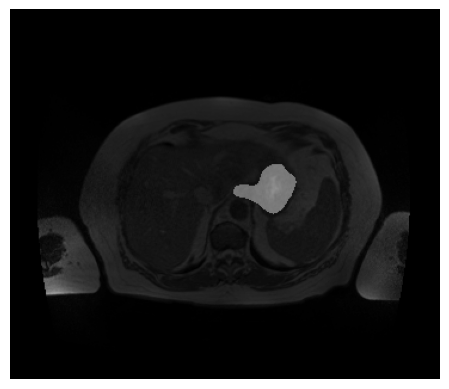

In [ ]:
plt.imshow(img_t.permute(1, 2, 0), cmap="gray")
plt.imshow(mask2.permute(1, 2, 0), cmap="gray", alpha=0.4)
plt.axis("off");

## Dataset prepration

### Load CSV file

In [ ]:
df = pd.read_csv(path.join(dataset_root, "train.csv"))
df.shape

(115488, 3)

In [ ]:
df.describe()

,id,class,segmentation
count,115488,115488,33913
unique,38496,3,33899
top,case30_day0_slice_0128,large_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
freq,3,38496,2


### Drop NaN values

In [ ]:
df.dropna(inplace=True)
display(df.head())
df.shape

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


(33913, 3)

### Find duplicate rows

In [ ]:
duplicates = df[df["segmentation"].duplicated(keep=False)]
display(duplicates)
duplicates.shape

,id,class,segmentation
3259,case133_day25_slice_0079,small_bowel,29755 2 30112 8 30468 14 30826 17 31185 19 315...
3262,case133_day25_slice_0080,small_bowel,29755 2 30112 8 30468 14 30826 17 31185 19 315...
3638,case133_day23_slice_0061,stomach,34757 14 35114 19 35473 21 35831 23 36189 26 3...
3641,case133_day23_slice_0062,stomach,34757 14 35114 19 35473 21 35831 23 36189 26 3...
13134,case15_day20_slice_0059,large_bowel,28436 5 28701 7 28966 8 29232 9 29498 9 29765 ...
13137,case15_day20_slice_0060,large_bowel,28436 5 28701 7 28966 8 29232 9 29498 9 29765 ...
24745,case115_day0_slice_0105,small_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
24748,case115_day0_slice_0106,small_bowel,16389 4 16648 15 16889 2 16913 24 17153 6 1717...
24751,case115_day0_slice_0107,small_bowel,16091 1 16114 4 16355 6 16379 8 16620 8 16644 ...
24754,case115_day0_slice_0108,small_bowel,16091 1 16114 4 16355 6 16379 8 16620 8 16644 ...


(28, 3)

### Create pivote table

In [ ]:
df = pd.pivot_table(df, index="id", columns="class", values="segmentation", aggfunc="first")
df.reset_index(inplace=True)

display(df.head())
df.shape

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,NaN,NaN,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,NaN,NaN,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,NaN,NaN,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,NaN,NaN,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,NaN,NaN,28918 9 29182 14 29446 18 29711 21 29976 23 30...


(16590, 4)

### Fill NaNs

In [ ]:
df.fillna('', inplace=True)
df.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...


### Get image paths

In [ ]:
path_ls = glob(path.join(dataset_root, "train", "**", "*.png"), recursive=True)
len(path_ls), path_ls[0]

(38496,
 'F:\\ai\\deep_cotolist\\4_segmentation\\uw-madison-gi-tract-image-segmentation\\train\\case101\\case101_day20\\scans\\slice_0001_266_266_1.50_1.50.png')

### Create a dataframe contains image paths

In [ ]:
id_ls = []

for p in path_ls:
    comps = p.split(path.sep)
    id_ls.append('_'.join([comps[-3], comps[-1]]).rsplit('_', 4)[0]    )

df_path = pd.DataFrame()
df_path["id"] = id_ls
df_path["path"] = path_ls
df_path

,id,path
0,case101_day20_slice_0001,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
1,case101_day20_slice_0002,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
2,case101_day20_slice_0003,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
3,case101_day20_slice_0004,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
4,case101_day20_slice_0005,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
...,...,...
38491,case92_day0_slice_0140,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
38492,case92_day0_slice_0141,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
38493,case92_day0_slice_0142,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
38494,case92_day0_slice_0143,F:\ai\deep_cotolist\4_segmentation\uw-madison-...


### Merge df and df_path

In [ ]:
df = df.merge(df_path, on="id")
df.head()

,id,large_bowel,small_bowel,stomach,path
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...


### Augment dataframe by adding new features

In [ ]:
df["case"] = df.id.apply(lambda x: x.split('_')[0].strip("case"))
df["day"] = df.id.apply(lambda x: x.split('_')[1].strip("day"))
df["slice"] = df.id.apply(lambda x: x.split('_')[3])
df["width"] = df.path.apply(lambda x: int(x[:-4].rsplit('_', 4)[1]))
df["height"] = df.path.apply(lambda x: int(x[:-4].rsplit('_', 4)[2]))
df["counts"] = np.sum(df.iloc[:, 1:4] != '', axis=1).values
df

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0070,266,266,1
...,...,...,...,...,...,...,...,...,...,...,...
16585,case9_day22_slice_0115,38022 2 38380 7 38739 9 39099 10 39295 6 39459...,21360 7 21718 10 22077 12 22435 15 22788 1 227...,,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,9,22,0115,360,310,2
16586,case9_day22_slice_0116,38021 4 38379 8 38739 10 38938 2 39099 10 3929...,21361 3 21718 9 22076 12 22435 14 22794 17 231...,,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,9,22,0116,360,310,2
16587,case9_day22_slice_0117,38020 7 38379 10 38738 12 38936 4 39098 12 392...,21717 8 22076 11 22434 15 22791 20 23149 25 23...,,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,9,22,0117,360,310,2
16588,case9_day22_slice_0118,37661 5 38019 10 38378 12 38738 12 39097 14 39...,21359 6 21717 10 22074 15 22431 20 22790 23 23...,,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,9,22,0118,360,310,2


### Create Train, Eval, Test subsets from dataset

#### Train

In [ ]:
train_cases = open(path.join(getcwd(), "train.txt")).read().replace("case", '').split('\n')
df_train = df[df.case.isin(train_cases)]
display(df_train.head())
df_train.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,101,20,0070,266,266,1


(12030, 11)

In [ ]:
df_train.to_csv(path.join(getcwd(), "train_subset.csv"), index=False)

#### Eval

In [ ]:
eval_cases = open(path.join(getcwd(), "validation.txt")).read().replace("case", '').split('\n')
df_eval = df[df.case.isin(eval_cases)]
display(df_eval.head())
df_eval.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
2763,case122_day0_slice_0051,,,35851 9 36211 12 36571 14 36931 14 37291 15 37...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,122,0,0051,360,310,1
2764,case122_day0_slice_0052,,,34414 2 34417 3 34772 8 35131 10 35490 12 3584...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,122,0,0052,360,310,1
2765,case122_day0_slice_0053,,,34419 1 34778 4 35131 12 35489 16 35848 18 362...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,122,0,0053,360,310,1
2766,case122_day0_slice_0054,,,33339 2 33697 6 34057 8 34416 10 34773 14 3512...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,122,0,0054,360,310,1
2767,case122_day0_slice_0055,,,32257 4 32615 8 32974 11 33333 14 33692 16 340...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,122,0,0055,360,310,1


(1493, 11)

In [ ]:
df_eval.to_csv(path.join(getcwd(), "eval_subset.csv"), index=False)

#### Test

In [ ]:
test_cases = open(path.join(getcwd(), "test.txt")).read().replace("case", '').split('\n')
df_test = df[df.case.isin(test_cases)]
display(df_test.head())
df_test.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
674,case110_day12_slice_0048,,,35874 3 36232 11 36591 14 36950 17 37310 18 37...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,110,12,0048,360,310,1
675,case110_day12_slice_0049,,,34429 12 34788 15 35147 17 35506 19 35865 22 3...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,110,12,0049,360,310,1
676,case110_day12_slice_0050,,,33709 6 34066 12 34424 18 34783 22 35141 26 35...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,110,12,0050,360,310,1
677,case110_day12_slice_0051,,,33347 8 33705 14 34063 19 34421 24 34779 28 35...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,110,12,0051,360,310,1
678,case110_day12_slice_0052,,,32988 6 33344 15 33702 20 34061 23 34419 26 34...,F:\ai\deep_cotolist\4_segmentation\uw-madison-...,110,12,0052,360,310,1


(3067, 11)

In [ ]:
df_test.to_csv(path.join(getcwd(), "test_subset.csv"), index=False)

## EDA

### Show an image and its mask

In [ ]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(normalizer_fn),
    T.Lambda(lambda x: x.repeat(3, 1, 1))
])

target_transform = T.Compose([T.Resize((224, 224))])

C:\Users\yasin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


red: large_bowel	green: small_bowel	blue: stomach


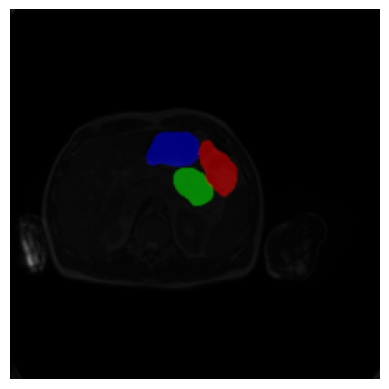

In [ ]:
item = np.random.randint(0, df_train.shape[0])
sample = df_train.iloc[item]

img = Image.open(sample["path"])

# img.size[::-1] swaps the width and height: (height, width) => (width, height)
mask = rle_decode(img.size[::-1], sample[["large_bowel", "small_bowel", "stomach"]])

img = train_transform(img)
mask = target_transform(mask)

plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.imshow(mask.permute(1, 2, 0), cmap="gray", alpha=0.5)
plt.axis("off")

print("red: large_bowel\tgreen: small_bowel\tblue: stomach")

### Plot histogram of the number of samples in each class

In [ ]:
large_bowel_not_nan = df_train.large_bowel[df_train.large_bowel != '']
small_bowel_not_nan = df_train.small_bowel[df_train.small_bowel != '']
stomach_not_nan = df_train.stomach[df_train.stomach != '']

large_bowel_not_nan.shape, small_bowel_not_nan.shape, stomach_not_nan.shape

((10143,), (8190,), (6191,))

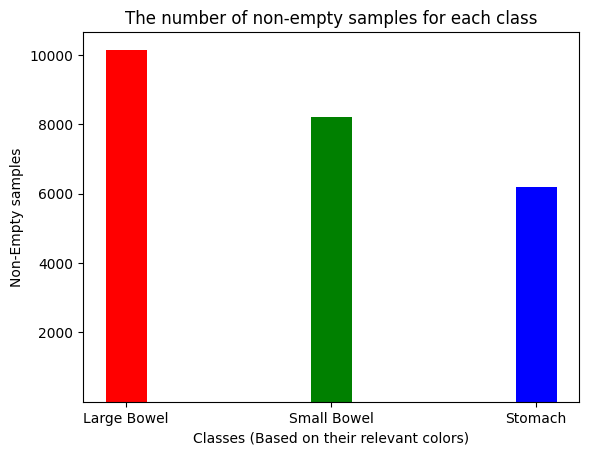

In [ ]:
lines = plt.bar(
        x=["Large Bowel", "Small Bowel", "Stomach"],
        height=[large_bowel_not_nan.shape[0], small_bowel_not_nan.shape[0], stomach_not_nan.shape[0]],
        width=0.2,
        color=["red", "green", "blue"],
        bottom=[4., 6., 2.]);

plt.title("The number of non-empty samples for each class")
plt.xlabel("Classes (Based on their relevant colors)")
plt.ylabel("Non-Empty samples");

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12030 entries, 0 to 16589
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12030 non-null  object
 1   large_bowel  12030 non-null  object
 2   small_bowel  12030 non-null  object
 3   stomach      12030 non-null  object
 4   path         12030 non-null  object
 5   case         12030 non-null  object
 6   day          12030 non-null  object
 7   slice        12030 non-null  object
 8   width        12030 non-null  int64 
 9   height       12030 non-null  int64 
 10  counts       12030 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 1.1+ MB


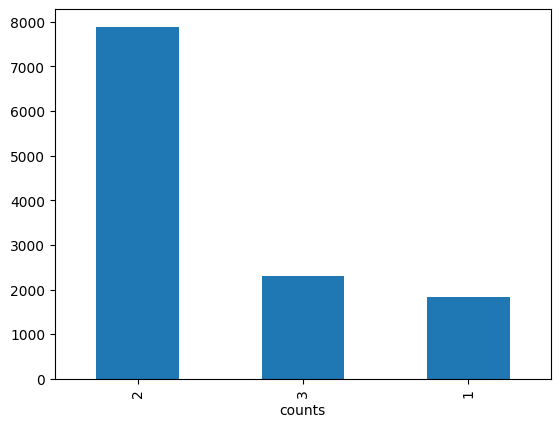

In [ ]:
df_train["counts"].value_counts().plot(kind="bar");

### Plot histogram of the number of samples each case

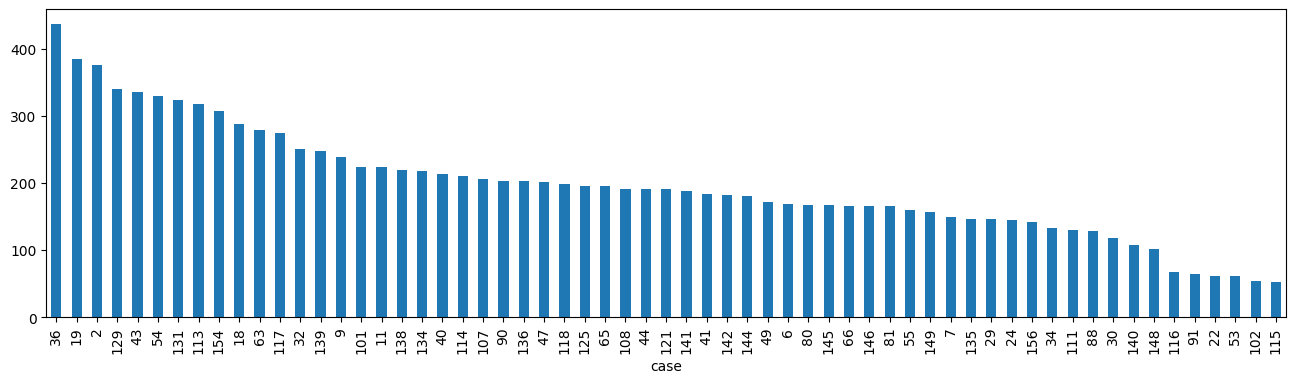

In [ ]:
plt.figure(figsize=(16, 4))
df_train.case.value_counts().plot(kind="bar");

### Plot histogram of image sizes

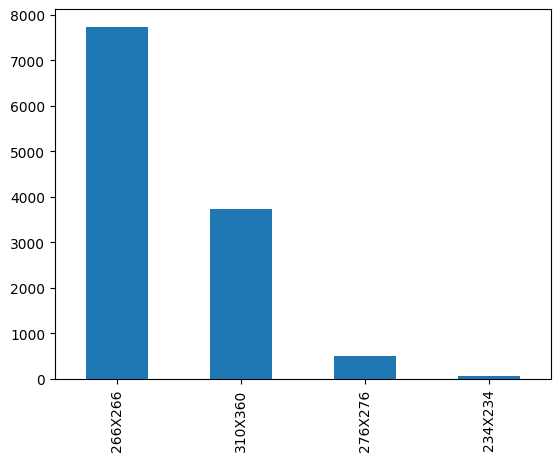

In [ ]:
img_sizes = df_train.height.apply(lambda x: str(x)) + 'X' + df_train.width.apply(lambda x: str(x))
img_sizes.value_counts().plot(kind="bar");

### Plot histogram of image sizes (MB)

## Custom dataset

In [ ]:
class UWMadisonDataset(VisionDataset):
    def __init__(self, csv_file: str, transforms: Optional[Callable]=None, memory: Optional[bool]=False):
        super(UWMadisonDataset, self).__init__(transforms=transforms)

        self.df = pd.read_csv(csv_file)
        self.classes = ["large_bowel", "small_bowel", "stomach"]

        self.img_ls = []

        self.memory = memory
        if memory:
            self._save_memory()

    def __getitem__(self, item_idx):
        sample = self.df.iloc[item_idx]

        img = self.img_ls[item_idx] if self.memory else self._load_image(sample.path)

        mask = rle_decode(img.shape[1::], sample[self.classes])
        mask = tv_tensors.Mask(mask)

        if self.transforms is not None:
            img, mask = self.transforms(img, mask)

        return img, mask.int()

    def __len__(self):
        return self.df.shape[0]

    def _save_memory(self):
        for img_path in self.df.path:
            img = self._load_image(img_path)
            self.img_ls.append(img)

    def _load_image(self, img_path):
        img = Image.open(img_path)
        img = self._normalizer(img)

        return tv_tensors.Image(img)

    def _normalizer(self, img):
        img = F.to_tensor(img)
        return np.array([(img - img.min()) / (img.max() - img.min())], dtype=np.float32)[0]

In [ ]:
transform_train = T.Compose([
    T.Resize(size=(234,), antialias=True),
    T.RandomCrop(size=(224, 224)),
    T.RandomPhotometricDistort(p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.Lambda(normalizer_fn),
    T.Normalize(mean=(0.5,), std=(0.5,)),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

transform_eval = T.Compose([
    T.Resize(size=(224, 224), antialias=True),
    T.Lambda(normalizer_fn),
    T.Normalize(mean=(0.5,), std=(0.5,)),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    ])

In [ ]:
start_time = datetime.now().replace(microsecond=0)

train_set = UWMadisonDataset(path.join(getcwd(), "train_subset.csv"), transforms=transform_train, memory=True)
eval_set = UWMadisonDataset(path.join(getcwd(), "eval_subset.csv"), transforms=transform_eval, memory=True)
test_set = UWMadisonDataset(path.join(getcwd(), "test_subset.csv"), transforms=transform_eval)

end_time = datetime.now().replace(microsecond=0)

print(f"Calculation Time: {end_time - start_time}")

len(train_set), len(eval_set), len(test_set)

Calculation Time: 0:01:07


(12030, 1493, 3067)

Image:	 torch.Size([3, 224, 224]) torch.float32 -1.0 1.0
Mask:	 torch.Size([3, 224, 224]) torch.int32 0 1


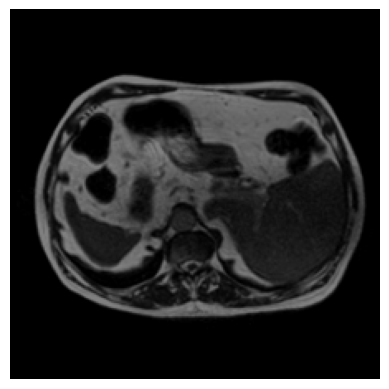

In [ ]:
rand_idx = np.random.randint(0, len(train_set))
img, mask = train_set[rand_idx]

print("Image:\t", img.shape, img.dtype, img.min().item(), img.max().item())
print("Mask:\t", mask.shape, mask.dtype, mask.min().item(), mask.max().item())

plt.imshow(img[0], cmap="gray")
plt.imshow(mask.permute(1, 2, 0), alpha=0.5)
plt.axis("off");

Image:	 torch.Size([3, 224, 224]) torch.float32 -1.0 1.0
Mask:	 torch.Size([3, 224, 224]) torch.int32 0 1


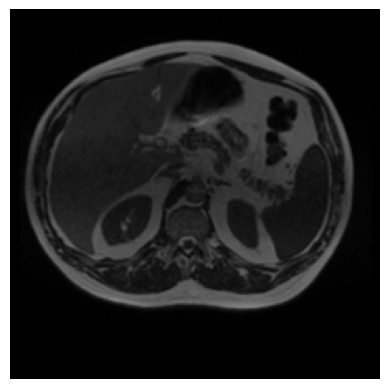

In [ ]:
rand_idx = np.random.randint(0, len(test_set))
img, mask = test_set[rand_idx]

print("Image:\t", img.shape, img.dtype, img.min().item(), img.max().item())
print("Mask:\t", mask.shape, mask.dtype, mask.min().item(), mask.max().item())

plt.imshow(img[0], cmap="gray")
plt.imshow(mask.permute(1, 2, 0), alpha=0.5)
plt.axis("off");

## Dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=batch_size*2)
test_loader = DataLoader(test_set, batch_size=batch_size*2)

In [ ]:
img, mask = next(iter(train_loader))

img.shape, mask.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 3, 224, 224]))

# Model

In [ ]:
model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", in_channels=3, classes=num_classes).to(device)

num_parameters(model)

The number of trainable parameters: 8,757,395


# Full Train

## Metrics, ...

In [ ]:
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

## Check paths

### Forward

In [ ]:
img, mask = next(iter(train_loader))

with torch.no_grad():
    img, mask = img.to(device), mask.to(device)
    yp = model(img)
    loss = loss_fn(yp, mask)

torch.cuda.empty_cache()

loss.item()

0.9966384172439575

### Backward

In [ ]:
optimizer_fn = SGD(model.parameters(), lr=0.5, momentum=0.9)

In [ ]:
mini_portion = 0.1

_, mini_train_set = random_split(train_set, lengths=[1-mini_portion, mini_portion])
_, mini_eval_set = random_split(eval_set, lengths=[1-mini_portion, mini_portion])

len(mini_train_set), len(mini_eval_set)

(1203, 149)

In [ ]:
mini_train_loader = DataLoader(mini_train_set, batch_size=batch_size, shuffle=True)
mini_eval_loader = DataLoader(mini_eval_set, batch_size=batch_size)

In [ ]:
for ep in range(5):
    model, _, _ = train_one_epoch(mini_train_loader, model, optimizer_fn, loss_fn, metric_fn, avg_fn, ep, device)
    eval_one_epoch(mini_eval_loader, model, loss_fn, metric_fn, avg_fn, device)

torch.cuda.empty_cache()

Epoch 0: 100%|██████████| 19/19 [00:21<00:00,  1.11s/ batch, loss=0.693, metric=0.0252]


Eval ==> loss: 0.6777	metric: 0.0



Epoch 1: 100%|██████████| 19/19 [00:21<00:00,  1.14s/ batch, loss=0.552, metric=0]


Eval ==> loss: 0.5499	metric: 0.3343



Epoch 2: 100%|██████████| 19/19 [00:21<00:00,  1.14s/ batch, loss=0.487, metric=0.412]


Eval ==> loss: 0.4922	metric: 0.4254



Epoch 3: 100%|██████████| 19/19 [00:21<00:00,  1.13s/ batch, loss=0.459, metric=0.422]


Eval ==> loss: 0.5105	metric: 0.3242



Epoch 4: 100%|██████████| 19/19 [00:21<00:00,  1.15s/ batch, loss=0.441, metric=0.423]


Eval ==> loss: 0.4556	metric: 0.3895



## Find efficient Hyper-Parameters

In [ ]:
for lr in [0.01, 0.1, 0.3, 0.5, 0.9]:
    for wd in [0, 1e-4]:
        print(f"\nLR: {lr}\tWD: {wd}")

        optimizer_fn = SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
        model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", in_channels=3, classes=num_classes).to(device)

        for ep in range(3):
            model, _, _ = train_one_epoch(train_loader, model, optimizer_fn, loss_fn, metric_fn, avg_fn, ep, device)
            eval_one_epoch(eval_loader, model, loss_fn, metric_fn, avg_fn, device)

        torch.cuda.empty_cache()


LR: 0.01	WD: 0


Epoch 0: 100%|██████████| 188/188 [03:37<00:00,  1.16s/ batch, loss=0.862, metric=0.0379]


Eval ==> loss: 0.8414	metric: 0.02065



Epoch 1: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.862, metric=0.0378]


Eval ==> loss: 0.8476	metric: 0.03175



Epoch 2: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.862, metric=0.0379]


Eval ==> loss: 0.8496	metric: 0.03656


LR: 0.01	WD: 0.0001


Epoch 0: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.872, metric=0.023]


Eval ==> loss: 0.8736	metric: 0.02931



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.872, metric=0.023]


Eval ==> loss: 0.8707	metric: 0.02698



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.872, metric=0.023]


Eval ==> loss: 0.8696	metric: 0.0278


LR: 0.1	WD: 0


Epoch 0: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.941, metric=0.0235]


Eval ==> loss: 0.9602	metric: 0.02266



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.941, metric=0.0235]


Eval ==> loss: 0.9673	metric: 0.02248



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.941, metric=0.0235]


Eval ==> loss: 0.9648	metric: 0.02353


LR: 0.1	WD: 0.0001


Epoch 0: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.928, metric=0.0309]


Eval ==> loss: 0.8995	metric: 0.02383



Epoch 1: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.928, metric=0.0309]


Eval ==> loss: 0.9159	metric: 0.02387



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.928, metric=0.0309]


Eval ==> loss: 0.9224	metric: 0.02876


LR: 0.3	WD: 0


Epoch 0: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.933, metric=0.0415]


Eval ==> loss: 0.9149	metric: 0.03069



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.933, metric=0.0415]


Eval ==> loss: 0.9284	metric: 0.03149



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.933, metric=0.0414]


Eval ==> loss: 0.9322	metric: 0.03063


LR: 0.3	WD: 0.0001


Epoch 0: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.896, metric=0.0243]


Eval ==> loss: 0.8713	metric: 0.02747



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.896, metric=0.0242]


Eval ==> loss: 0.8846	metric: 0.02886



Epoch 2: 100%|██████████| 188/188 [03:35<00:00,  1.15s/ batch, loss=0.896, metric=0.0242]


Eval ==> loss: 0.8851	metric: 0.02646


LR: 0.5	WD: 0


Epoch 0: 100%|██████████| 188/188 [03:35<00:00,  1.15s/ batch, loss=0.851, metric=0.0163]


Eval ==> loss: 0.8164	metric: 0.01045



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.851, metric=0.0162]


Eval ==> loss: 0.8159	metric: 0.01451



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.851, metric=0.0163]


Eval ==> loss: 0.8135	metric: 0.01723


LR: 0.5	WD: 0.0001


Epoch 0: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.896, metric=0.0487]


Eval ==> loss: 0.9074	metric: 0.02835



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.896, metric=0.0487]


Eval ==> loss: 0.9043	metric: 0.02725



Epoch 2: 100%|██████████| 188/188 [03:35<00:00,  1.15s/ batch, loss=0.896, metric=0.0487]


Eval ==> loss: 0.9061	metric: 0.02765


LR: 0.9	WD: 0


Epoch 0: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.944, metric=0.0404]


Eval ==> loss: 0.8928	metric: 0.03348



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.944, metric=0.0404]


Eval ==> loss: 0.9133	metric: 0.04352



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.944, metric=0.0405]


Eval ==> loss: 0.9201	metric: 0.04722


LR: 0.9	WD: 0.0001


Epoch 0: 100%|██████████| 188/188 [03:35<00:00,  1.15s/ batch, loss=0.937, metric=0.0395]


Eval ==> loss: 0.8881	metric: 0.02533



Epoch 1: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.937, metric=0.0396]


Eval ==> loss: 0.925	metric: 0.03559



Epoch 2: 100%|██████████| 188/188 [03:36<00:00,  1.15s/ batch, loss=0.937, metric=0.0395]


Eval ==> loss: 0.9444	metric: 0.03784



## Train

In [ ]:
model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", in_channels=3, classes=num_classes).to(device)

num_parameters(model)

The number of trainable parameters: 8,757,395


In [ ]:
epochs = 8
optimizer_fn = SGD(model.parameters(), lr=0.3, weight_decay=1e-4, momentum=0.9)
scheduler = lr_scheduler.MultiStepLR(optimizer_fn, milestones=[3, 6], gamma=0.33)

In [ ]:
best_model = model
min_eval_loss = torch.inf

In [ ]:
train_loss_hist, train_metric_hist = [], []
eval_loss_hist, eval_metric_hist = [], []

In [ ]:
start_time = datetime.now().replace(microsecond=0)

for ep in range(epochs):
    model, train_loss, train_metric = train_one_epoch(train_loader, model, optimizer_fn, loss_fn, metric_fn, avg_fn, ep, device)
    eval_loss, eval_metric = eval_one_epoch(eval_loader, model, loss_fn, metric_fn, avg_fn, device)

    scheduler.step()

    train_loss_hist.append(train_loss)
    train_metric_hist.append(train_metric)
    eval_loss_hist.append(eval_loss)
    eval_metric_hist.append(eval_metric)

    if min_eval_loss > eval_loss:
        min_eval_loss = eval_loss
        best_model = model

end_time = datetime.now().replace(microsecond=0)

torch.cuda.empty_cache()

print(f"Calculation Time: {end_time - start_time}")

Epoch 0: 100%|██████████| 188/188 [03:35<00:00,  1.15s/ batch, loss=0.362, metric=0.52]


Eval ==> loss: 0.2904	metric: 0.6359



Epoch 1: 100%|██████████| 188/188 [03:37<00:00,  1.16s/ batch, loss=0.154, metric=0.792]


Eval ==> loss: 0.2475	metric: 0.6912



Epoch 2: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.129, metric=0.824]


Eval ==> loss: 0.2801	metric: 0.6631



Epoch 3: 100%|██████████| 188/188 [03:39<00:00,  1.17s/ batch, loss=0.11, metric=0.849]


Eval ==> loss: 0.1738	metric: 0.7749



Epoch 4: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.104, metric=0.858]


Eval ==> loss: 0.1654	metric: 0.7853



Epoch 5: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.0994, metric=0.864]


Eval ==> loss: 0.1711	metric: 0.7775



Epoch 6: 100%|██████████| 188/188 [03:39<00:00,  1.17s/ batch, loss=0.0953, metric=0.87]


Eval ==> loss: 0.1641	metric: 0.7856



Epoch 7: 100%|██████████| 188/188 [03:38<00:00,  1.16s/ batch, loss=0.0931, metric=0.873]


Eval ==> loss: 0.1682	metric: 0.7819

Calculation Time: 0:30:52


# Plot

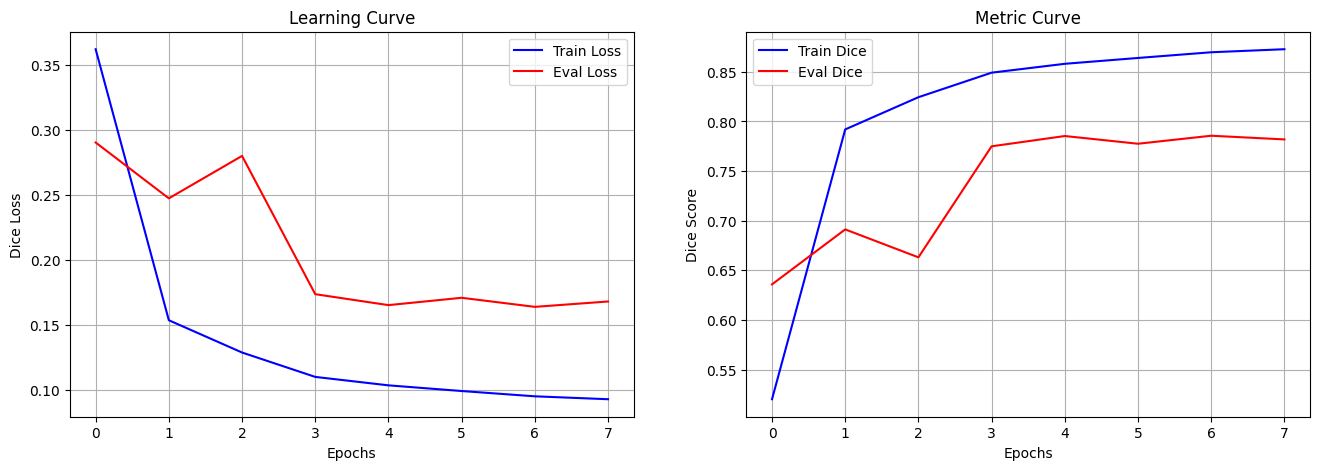

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axs[0].plot(train_loss_hist, c='b', label="Train Loss")
axs[0].plot(eval_loss_hist, c='r', label="Eval Loss")
axs[0].set_ylabel("Dice Loss")
axs[0].set_title("Learning Curve")

axs[1].plot(train_metric_hist, c='b', label="Train Dice")
axs[1].plot(eval_metric_hist, c='r', label="Eval Dice")
axs[1].set_ylabel("Dice Score")
axs[1].set_title("Metric Curve")

for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel("Epochs")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(best_model.to("cpu"), "/content/drive/MyDrive/Colab Notebooks/segmentation/best_model.pth")

# Testing Phase

In [ ]:
final_model = torch.load("./best_model_efficientnet_b4_as_encoder.pth", weights_only=False)
num_parameters(final_model)

The number of trainable parameters: 20,225,979


In [ ]:
start_time = datetime.now().replace(microsecond=0)

with torch.inference_mode():
    final_model.to(device)
    test_loss_val, test_metric_val = eval_one_epoch(test_loader, final_model, loss_fn, metric_fn, avg_fn, device)

end_time = datetime.now().replace(microsecond=0)

print(f"Calculation Time: {end_time - start_time}");

Eval ==> loss: 0.1649	metric: 0.7877

Calculation Time: 0:02:32


# Segmentation

## Load the best model

In [ ]:
final_model = torch.load("./best_model_efficientnet_b4_as_encoder.pth", weights_only=False)
num_parameters(final_model)

The number of trainable parameters: 20,225,979


## Plot a sample and its segmented mask

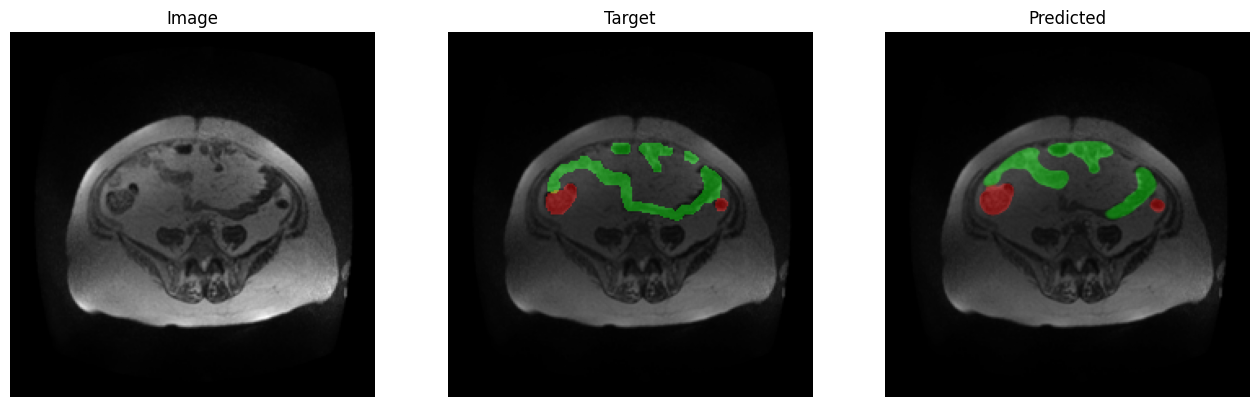

In [ ]:
final_model.to("cpu")

rand_idx = torch.randint(0, len(test_set), (1,)).item()
test_img, test_mask = test_set[rand_idx]

yp = segmente_fn(final_model, test_img)[0]

yp.shape, test_img.shape, test_mask.shape

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

alpha = 0.4

axs[0].imshow(test_img[0], cmap="gray")
axs[0].set_title("Image")

axs[1].imshow(test_img[0], cmap="gray")
axs[1].imshow(test_mask.permute(1, 2, 0).float(), cmap="gray", alpha=alpha)
axs[1].set_title("Target")

axs[2].imshow(test_img[0], cmap="gray")
axs[2].imshow(yp.permute(1, 2, 0), cmap="gray", alpha=alpha)
axs[2].set_title("Predicted")

for ax in axs:
    ax.axis("off");

## Plot some samples and their segmented mask

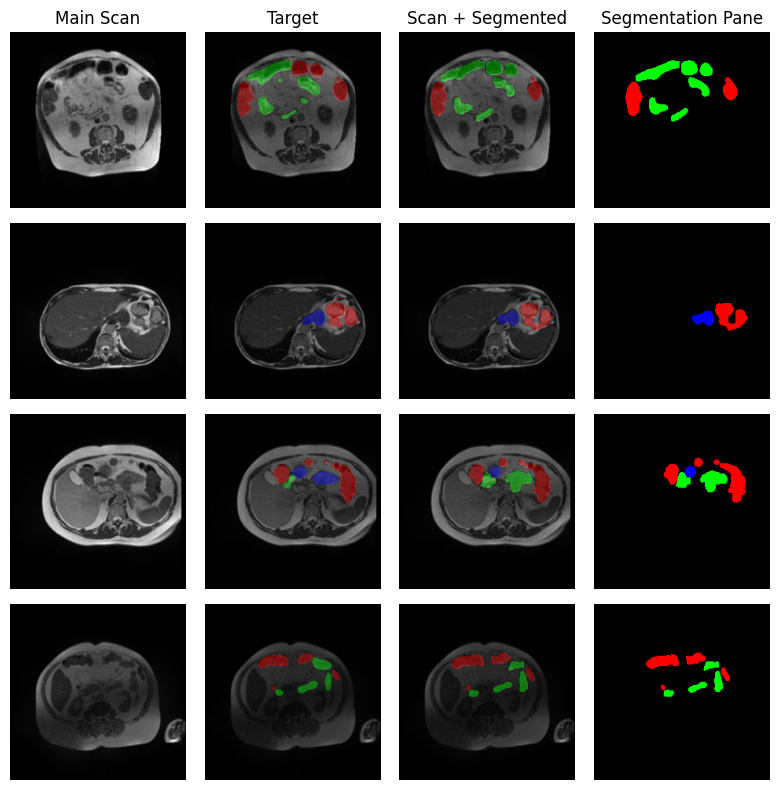

In [ ]:
final_model.to("cpu")

alpha = 0.4
num_rands = 4
rand_idx = torch.randint(0, len(test_set), (num_rands,))
titles = ["Main Scan", "Target", "Scan + Segmented", "Segmentation Pane"]

fig, axs = plt.subplots(nrows=num_rands, ncols=4, figsize=(8, 8), tight_layout=True)

for i, ax in enumerate(axs[0]):
    ax.set_title(titles[i])

for ax, idx in zip(axs, rand_idx):
    test_img, test_mask = test_set[idx.item()]

    yp = segmente_fn(final_model, test_img)[0]

    ax[0].imshow(test_img[0], cmap="gray")

    ax[1].imshow(test_img[0], cmap="gray")
    ax[1].imshow(yp.permute(1, 2, 0), cmap="gray", alpha=alpha)

    ax[2].imshow(test_img[0], cmap="gray")
    ax[2].imshow(test_mask.permute(1, 2, 0).float(), cmap="gray", alpha=alpha)

    ax[3].imshow(test_mask.permute(1, 2, 0).float(), cmap="gray")

    for _ax in ax:
        _ax.axis("off");

In [ ]:
fig.savefig("figure.png", dpi=300, bbox_inches="tight")

# More Experiments

## Load the best model

In [ ]:
final_model = torch.load("./best_model_efficientnet_b4_as_encoder.pth", weights_only=False)
num_parameters(final_model)

The number of trainable parameters: 20,225,979


## Concat Test and Eval sets and get the predicted mask on them

In [ ]:
new_test_set = ConcatDataset([eval_set, test_set])
new_test_loader = DataLoader(new_test_set, batch_size=batch_size)

len(new_test_set)

4560

In [ ]:
start_time =  datetime.now().replace(microsecond=0)

segmented_ls = []

with torch.inference_mode():
    final_model.to(device)

    for img, mask in new_test_loader:
        img, mask = img.to(device), mask.to(device)

        segmented = segmente_fn(final_model, img)
        segmented_ls.append(segmented)

torch.cuda.empty_cache()

end_time =  datetime.now().replace(microsecond=0)

print(f"New test set length: {len(segmented_ls)}")

print(f"Calculation Time: {end_time - start_time}")

New test set length: 72
Calculation Time: 0:02:38


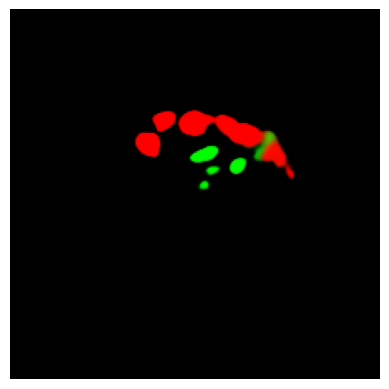

In [ ]:
plt.imshow(segmented_ls[40][0].permute(1, 2, 0).float(), cmap="gray")
plt.axis("off");

## Calculate Dice Score on each class seperately

In [ ]:
large_bowel_score = Dice(ignore_index=0)
small_bowel_score = Dice(ignore_index=0)
stomach_score = Dice(ignore_index=0)

In [ ]:
for predicted, (_, mask) in zip (segmented_ls, new_test_loader):
    print(predicted[0, 0].shape, mask[0, 0].shape)
    break

torch.Size([224, 224]) torch.Size([224, 224])


In [ ]:
for predicted, (_, mask) in zip (segmented_ls, new_test_loader):
    print(predicted[:, 0, ...].shape, mask[:, 0].shape)
    break

torch.Size([64, 224, 224]) torch.Size([64, 224, 224])


In [ ]:
for predicted, (_, mask) in zip (segmented_ls, new_test_loader):
    large_bowel_score.update(predicted[:, 0], mask[:, 0])
    small_bowel_score.update(predicted[:, 1], mask[:, 1])
    stomach_score.update(predicted[:, 2], mask[:, 2])

print(f'Large Bowel Dice: {large_bowel_score.compute().item():.4}')
print(f'Small Bowel Dice: {small_bowel_score.compute().item():.4}')
print(f'Stomach Dice: {stomach_score.compute().item():.4}')

Large Bowel Dice: 0.8093
Small Bowel Dice: 0.7203
Stomach Dice: 0.8632


## Confusion matrix

In [ ]:
tp, fp, tn, fn = smp.metrics.get_stats(segmented_ls[-1], mask.cpu(), mode="multilabel", threshold=0.5)
tp.shape, fp.shape, tn.shape, fn.shape

(torch.Size([16, 3]),
 torch.Size([16, 3]),
 torch.Size([16, 3]),
 torch.Size([16, 3]))